# COMP9727 Assignment 1
WenquWang z5539497

# Part 1



### basic setups

In [81]:
# read files from GoogleDrive
from google.colab import drive
drive.mount('/content/drive')
master_path = '/content/drive/MyDrive/COMP9727/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
import nltk
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

df = pd.read_csv(master_path + 'dataset.tsv', sep='\t')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Preprocess as in tutorial

In [83]:
pd.set_option('display.width', 280)
pd.set_option('display.max_colwidth', 240)
print(df.head(20))

                             artist_name                                               track_name  release_date    genre  \
0                                 loving                                        the not real lake          2016     rock   
1                                incubus                                          into the summer          2019     rock   
2                              reignwolf                                                 hardcore          2016    blues   
3                   tedeschi trucks band                                                   anyhow          2016    blues   
4   lukas nelson and promise of the real                                        if i started over          2017    blues   
5                                tia ray                                             just my luck          2018     jazz   
6                             rebelution                                                trap door          2018   reggae   
7       

In [84]:
# Drop duplicates and missing values
df = df.drop_duplicates()
df = df.dropna()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1480 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_name   1480 non-null   object
 1   track_name    1480 non-null   object
 2   release_date  1480 non-null   int64 
 3   genre         1480 non-null   object
 4   lyrics        1480 non-null   object
 5   topic         1480 non-null   object
dtypes: int64(1), object(5)
memory usage: 80.9+ KB
None


## TEST



In [85]:
def clean_text(txt):
  txt = txt.lower()
  txt = re.sub(r"[^a-z0-9'/\s]", " ", txt) #no longer removes / ' and numbers
  tokens = txt.split()
  return " ".join(tokens)


In [86]:
print(clean_text("I'm aaa AAA !!! !@#$%^&*() space   mId   6 spaces 24/7"))

i'm aaa aaa space mid 6 spaces 24/7


## Q1+Q2+Q3


In [87]:
import functools
import numpy as np
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import ParameterGrid
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, Binarizer
from sklearn.model_selection import StratifiedKFold, cross_val_score, ParameterGrid, cross_validate
from nltk.corpus import stopwords as nltk_stop
nltk.download('stopwords')
nltk.download('wordnet')
stemmer    = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Q1.1 trying different clean pattern: keep numbers and symbol ' / ; keep only numbers; keep more symbols

Keep ' and / because there might be I'm, he's existing in lyrics, / for 24/7 or 1/3.

In [88]:
clean_patterns = {
  "less_symbol": r"[^a-z0-9'/\s]",
  "default": r"[^a-z0-9\s]",
  "more_symbol": r"[^a-z0-9'/#@\s]"
}

Q2 Build a function generator to generate analyze function depending on params: wether do lower case, which clean pattern, which tokenize mode (stemmer or lemmatizer), which stop word filtering, ngram length (unigram and bigram). Analyze function is later used in grid search, trying to find best combination of params

In [89]:
def make_analyzer(lower: bool, pattern: str, tok_mode: str, stop_option: str or None, ngram_range: tuple):
  # selection of stop words
  if stop_option == "sklearn":
    raw_stop = __import__('sklearn').feature_extraction.text.ENGLISH_STOP_WORDS
  elif stop_option == "nltk":
    raw_stop = set(nltk_stop.words("english"))
  else:
    raw_stop = None

  # if using stop words, do the same pre process (cleaning) as text
  if raw_stop is not None:
    processed_stop = set()
    for sw in raw_stop:
      txt = sw.lower() if lower else sw
      txt = re.sub(clean_patterns[pattern], " ", txt)
      toks = txt.split()
      # select by tokenize param
      if tok_mode == "stem":
        toks = [stemmer.stem(w) for w in toks]
      elif tok_mode == "lemma":
        toks = [lemmatizer.lemmatize(w) for w in toks]
      processed_stop.update(toks)
  else:
    processed_stop = None

  # actual cleaning and tokenization.
  def analyzer(doc: str):
    # wether do lowercase (nolonger needed)
    # txt = doc.lower() if lower else doc
    txt = doc
    txt = re.sub(clean_patterns[pattern], " ", txt)
    # do basic split(global)
    tokens = txt.split()
    # stem/lemma
    if tok_mode == "stem":
      tokens = [stemmer.stem(w) for w in tokens]
    elif tok_mode == "lemma":
      tokens = [lemmatizer.lemmatize(w) for w in tokens]
    # stop word filter
    if processed_stop is not None:
      tokens = [w for w in tokens if w not in processed_stop]
    # n-gram
    min_n, max_n = ngram_range
    if max_n == 1:
      return tokens
    out = []
    L = len(tokens)
    for n in range(min_n, max_n+1):
      for i in range(L-n+1):
        out.append(" ".join(tokens[i:i+n]))
    return out

  return analyzer

Building pipeline for grid search,initialize vectorizer and pass all necessary params to analyzer closure (to generate results under diferent parameter combinations). All process in vectorizer must be explicitly set to false or none, otherwise will cause warning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', ..........] not in stop_words.

Which actually over tokenized stop word list(? not sure) and will affect result.

In [90]:
def build_pipeline(clf, clean_pattern="default", lower=True, stop_option=None, ngram=(1,1), tok_mode="none"):
  vect = CountVectorizer(
    analyzer=make_analyzer(lower, clean_pattern, tok_mode, stop_option, ngram),
    lowercase=False, # all set to none, process by analyzer
    preprocessor=None,
    tokenizer=None,
    token_pattern=None
  )
  steps = [("vect", vect)]
  if isinstance(clf, BernoulliNB): # add binarizer if BNB
    steps.append(("bin", Binarizer(copy=False)))
  steps.append(("clf", clf)) # mnb & bnb
  return Pipeline(steps)

Q2 Building param grid for grid search, trying all possible param combinations.

In [91]:
param_grid = {
  "clean_pattern": list(clean_patterns.keys()),
  "lower": [True, False], # actually not needed here, basically no uppercase letters in dataset, keeping in case of bugs
  "stop_option": [None, "sklearn", "nltk"],
  "ngram": [(1,1), (1,2)],
  "tok_mode": ["none", "stem", "lemma"]
}

Q1.2 using five fold cross validate

removed date from text col for it's basically irrevalent. keep the rest.

In [92]:
text_cols = ["artist_name", "track_name", "genre", "lyrics"]
df["all_text"] = (df[text_cols].fillna("").agg(" ".join, axis=1))
X = df["all_text"].astype(str).values
y = df["topic"].astype(str).values

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Q3 checking data balance, the distribution of types is close to uniform in some topics but unbalance on lifestyle and emotion topics. Accuracy may be dominated by dark, sadness and personal, taking both accuracy and f1_macro into account

In [93]:
vc = df["topic"].value_counts(normalize=True)
print(vc)

topic
dark         0.329054
sadness      0.250676
personal     0.230405
lifestyle    0.136486
emotion      0.053378
Name: proportion, dtype: float64


In [94]:
scoring = ["accuracy","f1_macro"]

Q3 perform grid search and cross validate on both BNB and MNB, and on all param combination listed in previous cells.

For each round, record model (bnb and mnb), and param combinations. Also record mean accuracy, accuracy standard deviation, mean f1_macro, f1_macro standard deviation as result indicators. Using mainly mean accuracy & f1_macro as main indicator to sort result (aka model and param combination) quality.

Print top ten results.

In [95]:
records = []
rounds = 0
for params in ParameterGrid(param_grid): # under all possible param combination
  for clf in (BernoulliNB(), MultinomialNB()): # checking both BNB & MNB in one search
    pipe = build_pipeline(clf, **params)
    cv_res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=False)
    rounds += 1
    print(rounds)
    records.append({
      **params,
      "model": clf.__class__.__name__,
      "acc_mean": np.mean(cv_res["test_accuracy"]),
      "acc_std": np.std(cv_res["test_accuracy"]),
      "f1_mean": np.mean(cv_res["test_f1_macro"]),
      "f1_std": np.std(cv_res["test_f1_macro"])
    })

results = (pd.DataFrame(records).sort_values(["f1_mean","acc_mean"], ascending=False).reset_index(drop=True))
print(results.head(10))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
  clean_pattern  lower   ngram stop_option tok_mode          model  acc_mean   acc_std   f1_mean    f1_std
0       default   True  (1, 1)        nltk     stem  MultinomialNB  0.811486  0.014865  0.751374  0.029059
1       default  False  (1, 1)

Printing more results to evaluate both models. It's clear that MMB occupies top part of result sheet with noticable accuracy and f1_macro. This possibly because MNB takes word frequency info into account, thus having more expressive power. BNB only checks weather a word appears.



In [96]:
print(results.head(30))

   clean_pattern  lower   ngram stop_option tok_mode          model  acc_mean   acc_std   f1_mean    f1_std
0        default   True  (1, 1)        nltk     stem  MultinomialNB  0.811486  0.014865  0.751374  0.029059
1        default  False  (1, 1)        nltk     stem  MultinomialNB  0.811486  0.014865  0.751374  0.029059
2    less_symbol   True  (1, 1)        None    lemma  MultinomialNB  0.812162  0.008705  0.748214  0.026788
3    less_symbol  False  (1, 1)        None    lemma  MultinomialNB  0.812162  0.008705  0.748214  0.026788
4    more_symbol   True  (1, 1)        None    lemma  MultinomialNB  0.812162  0.008705  0.748214  0.026788
5    more_symbol  False  (1, 1)        None    lemma  MultinomialNB  0.812162  0.008705  0.748214  0.026788
6        default   True  (1, 1)        None    lemma  MultinomialNB  0.812162  0.008705  0.748020  0.027031
7        default  False  (1, 1)        None    lemma  MultinomialNB  0.812162  0.008705  0.748020  0.027031
8    less_symbol   True  (1,

In [97]:
print(results.tail(30))

    clean_pattern  lower   ngram stop_option tok_mode        model  acc_mean   acc_std   f1_mean    f1_std
186   more_symbol  False  (1, 2)        nltk     stem  BernoulliNB  0.335811  0.005489  0.110224  0.007932
187   more_symbol  False  (1, 2)        nltk    lemma  BernoulliNB  0.335811  0.005489  0.110224  0.007932
188   less_symbol   True  (1, 2)     sklearn     none  BernoulliNB  0.335811  0.006957  0.110212  0.009511
189   less_symbol  False  (1, 2)     sklearn     none  BernoulliNB  0.335811  0.006957  0.110212  0.009511
190       default   True  (1, 2)     sklearn     none  BernoulliNB  0.335811  0.006957  0.110212  0.009511
191       default  False  (1, 2)     sklearn     none  BernoulliNB  0.335811  0.006957  0.110212  0.009511
192   more_symbol   True  (1, 2)     sklearn     none  BernoulliNB  0.335811  0.006957  0.110212  0.009511
193   more_symbol  False  (1, 2)     sklearn     none  BernoulliNB  0.335811  0.006957  0.110212  0.009511
194       default   True  (1, 2)     

Colour belt of MNB and BNB distribution shows clearly that under previous evaluation (accuracy and f1_macro), MNB appears in top half of the belt.

[]

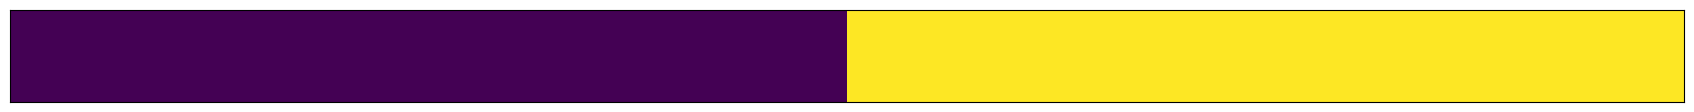

In [98]:
import matplotlib.pyplot as plt
models = results["model"]
counts = models.value_counts()


labels, unique_models = pd.factorize(models)
data = labels.reshape(1, -1)

fig, ax = plt.subplots(figsize=(len(models)/10, 1.2))
im = ax.imshow(data, aspect='auto')
ax.set_yticks([])
ax.set_xticks([])

Thus we finished Q1-3 with:

Removing less special characters(symols) by regex; apply 5 fold cross validate

Applying MNB model, make all step in prepross and other params (stop option,ngram,tokenize mode) selectable in grid search, and performing that grid search to find best setps & params that performs better.

Best param fixed as: default clean pattern(keep numbers,',/), ngram(1,1), stop words nltk(english), tokenize mode lemma(lemmatizer), model MultinomialNB

Compared both BNB and MNB when doing grid search (doubled amount of calculation, shouldn't do that), chosed mean accuracy and f1_macro due to distribution of topics. (accuracy for over all correct rate and f1_macro for accuracy of lifestyle and emotion not suppressed by other major topics). Finally confirmed that MNB outperformed BNB over all cases.

## Q4

Set up feature word num list, none for all words

In [99]:
N_list = [500, 1000, 2000, 5000, None]

Build same pipeline as previous, but fix param choice as best params.
Add N to count vectorizer as demanded.

In [101]:
# def build_pipeline(clf, clean_pattern="default", lower=True, stop_option=None, ngram=(1,1), tok_mode="none"):
#   vect = CountVectorizer(
#     analyzer=make_analyzer(lower, clean_pattern, tok_mode, stop_option, ngram),
#     lowercase=False, # all set to none, process by analyzer
#     preprocessor=None,
#     tokenizer=None,
#     token_pattern=None
#   )
#   steps = [("vect", vect)]
#   if isinstance(clf, BernoulliNB): # add binarizer if BNB
#     steps.append(("bin", Binarizer(copy=False)))
#   steps.append(("clf", clf)) # mnb & bnb
#   return Pipeline(steps)

def build_pipeline2(clf, N):
  vect = CountVectorizer(
    analyzer=make_analyzer(0, "default", "lemma", "nltk", (1,1)), # best params from result above (default clean pattern(keep numbers,',/), ngram(1,1), stop words nltk, tokenize mode lemma, model MultinomialNB)
    lowercase=False,
    preprocessor=None,
    tokenizer=None,
    token_pattern=None,
    max_features = N
  )
  steps = [("vect", vect)]
  if isinstance(clf, BernoulliNB): # add binarizer if BNB
    steps.append(("bin", Binarizer(copy=False)))
  steps.append(("clf", clf)) # mnb & bnb
  return Pipeline(steps)

First test on both BNB & MNB, result shows that MNB still outperforms BNB, stop using BNB.

In [102]:
records = []
rounds = 0
for N in N_list: # under all possible N
  for clf in (BernoulliNB(), MultinomialNB()): # checking both BNB & MNB in one search
    pipe = build_pipeline2(clf, N)
    cv_res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=False)
    rounds += 1
    print(rounds)
    records.append({
      "N_words": N,
      "model": clf.__class__.__name__,
      "acc_mean": np.mean(cv_res["test_accuracy"]),
      "acc_std": np.std(cv_res["test_accuracy"]),
      "f1_mean": np.mean(cv_res["test_f1_macro"]),
      "f1_std": np.std(cv_res["test_f1_macro"])
    })

results = (pd.DataFrame(records).sort_values(["f1_mean","acc_mean"], ascending=False).reset_index(drop=True))
print(results.head(10))

1
2
3
4
5
6
7
8
9
10
   N_words          model  acc_mean   acc_std   f1_mean    f1_std
0    500.0  MultinomialNB  0.878378  0.008810  0.859398  0.016812
1   1000.0  MultinomialNB  0.851351  0.019111  0.830415  0.027860
2   2000.0  MultinomialNB  0.837838  0.010895  0.812834  0.012560
3   5000.0  MultinomialNB  0.826351  0.011819  0.788593  0.024462
4      NaN  MultinomialNB  0.813514  0.010336  0.746636  0.027283
5    500.0    BernoulliNB  0.652703  0.019975  0.545675  0.025017
6   1000.0    BernoulliNB  0.634459  0.022348  0.517704  0.022559
7   2000.0    BernoulliNB  0.617568  0.018055  0.481111  0.013658
8   5000.0    BernoulliNB  0.566216  0.032235  0.391787  0.021503
9      NaN    BernoulliNB  0.537162  0.015555  0.336253  0.013826


Checking wether N<500 has better result.

In [103]:
N_list = [50, 100, 200, 400]
records = []
rounds = 0
for N in N_list: # under all possible param combination
  clf = MultinomialNB() # checking both BNB & MNB in one search
  pipe = build_pipeline2(clf, N)
  cv_res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=False)
  rounds += 1
  print(rounds)
  records.append({
    "N_words": N,
    "model": clf.__class__.__name__,
    "acc_mean": np.mean(cv_res["test_accuracy"]),
    "acc_std": np.std(cv_res["test_accuracy"]),
    "f1_mean": np.mean(cv_res["test_f1_macro"]),
    "f1_std": np.std(cv_res["test_f1_macro"])
  })

results = (pd.DataFrame(records).sort_values(["f1_mean","acc_mean"], ascending=False).reset_index(drop=True))
print(results.head(10))

1
2
3
4
   N_words          model  acc_mean   acc_std   f1_mean    f1_std
0      400  MultinomialNB  0.869595  0.009215  0.852948  0.017556
1      200  MultinomialNB  0.830405  0.007822  0.813398  0.007534
2      100  MultinomialNB  0.753378  0.024734  0.732895  0.023690
3       50  MultinomialNB  0.676351  0.035587  0.646436  0.032071


Confirm that N = around 500 is the best feature num value as it creats best over all accuracy and f1_macro.

In [104]:
N_list = [300, 350, 400, 450, 500, 550, 600]
records = []
rounds = 0
for N in N_list: # under all possible param combination
  clf = MultinomialNB() # checking both BNB & MNB in one search
  pipe = build_pipeline2(clf, N)
  cv_res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=False)
  rounds += 1
  print(rounds)
  records.append({
    "N_words": N,
    "model": clf.__class__.__name__,
    "acc_mean": np.mean(cv_res["test_accuracy"]),
    "acc_std": np.std(cv_res["test_accuracy"]),
    "f1_mean": np.mean(cv_res["test_f1_macro"]),
    "f1_std": np.std(cv_res["test_f1_macro"])
  })

results = (pd.DataFrame(records).sort_values(["f1_mean","acc_mean"], ascending=False).reset_index(drop=True))
print(results.head(10))

1
2
3
4
5
6
7
   N_words          model  acc_mean   acc_std   f1_mean    f1_std
0      500  MultinomialNB  0.878378  0.008810  0.859398  0.016812
1      550  MultinomialNB  0.875000  0.009791  0.853793  0.014487
2      400  MultinomialNB  0.869595  0.009215  0.852948  0.017556
3      450  MultinomialNB  0.872297  0.009411  0.852844  0.016944
4      600  MultinomialNB  0.873649  0.008964  0.851404  0.011281
5      350  MultinomialNB  0.864189  0.010978  0.849503  0.015358
6      300  MultinomialNB  0.864865  0.013681  0.846685  0.019362


## Q5

Choose logistic regression as the third model(for I used this in previous subjects of 9417 and it worked well)

Logistic regression is a linear classifier that predicts the probability of a category by perform a weighted linear combination of input features and apply sigmoid function. It is a discriminative model that directly models the posterior probability. It often performs stably in high-dimensional sparse text classification scenarios, and can control overfitting through regularization.

In this case with high dimentional and sparse lyrics, logistic regression can retain the interpretability of the linear model and also adjust the model complexity through regularization.Thus I chose this model. I assume this model will atleast outperform both MNB and BNB on f1_macro since it can minimize classification loss and use full word frequency information, and accuracy at least the same or higher.

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold

Still use the same pipeline function, add fixed N_word num

In [106]:
def build_pipeline3(clf):
  vect = CountVectorizer(
    analyzer=make_analyzer(0, "default", "lemma", "nltk", (1,1)), # best params from result above (default clean pattern(keep numbers,',/), ngram(1,1), stop words nltk, tokenize mode lemma, model MultinomialNB)
    lowercase=False,
    preprocessor=None,
    tokenizer=None,
    token_pattern=None,
    max_features = 500
  )
  steps = [("vect", vect)]
  if isinstance(clf, BernoulliNB): # add binarizer if BNB
    steps.append(("bin", Binarizer(copy=False)))
  steps.append(("clf", clf)) # mnb & bnb & lr
  return Pipeline(steps)

Still use the same 5 fold cross validate and evaluation based on accuracy and f1_macro. Apply same validate on 3 model under the same best params obtained above.

LR is applied at basically default settings, since lbfgs works well on small amount of data.

From the results we can see the mean accuracy and f1_macro are slightly higher than that of LR, which significantly higher than that of BNB.

MNB and LR shows relatively close results, but disconfirmed my assumption of LR being supiror to MNB. However its difference is smaller than 1%. I assume this is because parameter estimation of Naive Bayes is more stable in this data, and MNB as a generative model has better resistant to noise than LR. Also, the test is run under the best params of MNB, since I haven't do grid search based on LR, it might not be the best params for LR. So I cannot confirm MNB is better than LR in this case.

In [107]:
records = []
rounds = 0
#for N in N_list: # under all possible N
for clf in (BernoulliNB(), MultinomialNB(), LogisticRegression(penalty="l2", C=1.0, solver="lbfgs", max_iter=1000)): # apply LR with default settings
  pipe = build_pipeline3(clf)
  cv_res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=False)
  rounds += 1
  print(rounds)
  records.append({
    "model": clf.__class__.__name__,
    "acc_mean": np.mean(cv_res["test_accuracy"]),
    "acc_std": np.std(cv_res["test_accuracy"]),
    "f1_mean": np.mean(cv_res["test_f1_macro"]),
    "f1_std": np.std(cv_res["test_f1_macro"])
  })

results = (pd.DataFrame(records).sort_values(["f1_mean","acc_mean"], ascending=False).reset_index(drop=True))
print(results.head(10))

1
2
3
                model  acc_mean   acc_std   f1_mean    f1_std
0       MultinomialNB  0.878378  0.008810  0.859398  0.016812
1  LogisticRegression  0.867568  0.010768  0.848311  0.016608
2         BernoulliNB  0.652703  0.019975  0.545675  0.025017


  Thus the best model & params is fixed as:

  MNB

  make_analyzer(0, "default", "lemma", "nltk", (1,1))

  max_features = 500

# Part2

Q1

Train-test split as demanded. 0-750 751-1000. Keep the text cols as previous.
Triggred a chain assignment warning. Dose not matter.

In [171]:
df2 = pd.read_csv(master_path + 'dataset.tsv', sep='\t')

train = df2.iloc[:750]
test = df2.iloc[750:1000]

text_cols = ["artist_name", "track_name", "genre", "lyrics"]
train["all_text"] = (train[text_cols].fillna("").agg(" ".join, axis=1))
test["all_text"] = (test[text_cols].fillna("").agg(" ".join, axis=1))
X_train = train["all_text"].astype(str).values
y_train = train["topic"].astype(str).values
X_test = test["all_text"].astype(str).values
#y_test = test["topic"].astype(str).values # im a idiot (


/tmp/ipython-input-171-1204292954.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["all_text"] = (train[text_cols].fillna("").agg(" ".join, axis=1))
/tmp/ipython-input-171-1204292954.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["all_text"] = (test[text_cols].fillna("").agg(" ".join, axis=1))


Reuse the pipeline from above, train classifier on train set, generate topic prediction

In [170]:
# def build_pipeline3(clf):
#   vect = CountVectorizer(
#     analyzer=make_analyzer(0, "default", "lemma", "nltk", (1,1)), # best params from result above (default clean pattern(keep numbers,',/), ngram(1,1), stop words nltk, tokenize mode lemma, model MultinomialNB)
#     lowercase=False,
#     preprocessor=None,
#     tokenizer=None,
#     token_pattern=None,
#     max_features = 500
#   )
#   steps = [("vect", vect)]
#   if isinstance(clf, BernoulliNB): # add binarizer if BNB
#     steps.append(("bin", Binarizer(copy=False)))
#   steps.append(("clf", clf)) # mnb & bnb & lr
#   return Pipeline(steps)

pipe = build_pipeline3(MultinomialNB()) # params already in build pipeline3, only name clf
pipe.fit(X_train, y_train)
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)


Generate user's topic-keywords as matches, delete first line

In [169]:
user1_kw = {}
user2_kw = {}
user3_kw = {}
for line in open(master_path + 'user1.tsv', encoding="utf-8"): # generate match
  topic, kws = line.strip().split("\t")
  user1_kw[topic] = [w.strip().lower() for w in kws.split(",")]

for line in open(master_path + 'user2.tsv', encoding="utf-8"):
  topic, kws = line.strip().split("\t")
  user2_kw[topic] = [w.strip().lower() for w in kws.split(",")]

del user1_kw['topic'] # delete first line
del user2_kw['topic']
print(user1_kw,user2_kw)

{'dark': ['fire', 'enemy', 'pain', 'storm', 'fight'], 'sadness': ['cry', 'alone', 'heartbroken', 'tears', 'regret'], 'personal': ['dream', 'truth', 'life', 'growth', 'identity'], 'lifestyle': ['party', 'city', 'night', 'light', 'rhythm'], 'emotion': ['love', 'memory', 'hug', 'kiss', 'feel']} {'sadness': ['lost', 'sorrow', 'goodbye', 'tears', 'silence'], 'emotion': ['romance', 'touch', 'feeling', 'kiss', 'memory']}


For each song in train set, if prediction topic is current topic and there exist any user key word in text, consider this song as user liked. mark index of those songs in list as matches

In [148]:
topics = pipe.classes_.tolist()

def user_liked(user_kw, df, y_pred):
  liked = {t: [] for t in topics}
  for idx, row in df.iterrows():
    topic = y_pred[idx]
    text = (row['artist_name'] + ' ' + row['track_name'] + ' ' + row['genre'] + ' ' + row['lyrics']).lower()
    if any(kw in text for kw in user_kw.get(topic, [])): # found kw match, append song id into list
      liked[topic].append(idx)
  return liked

liked1 = user_liked(user1_kw, train, y_pred_train)
print(liked1)
liked2 = user_liked(user2_kw, train, y_pred_train)
print(liked2)

{'dark': [0, 8, 37, 52, 64, 68, 71, 72, 79, 81, 83, 88, 95, 97, 110, 113, 119, 129, 132, 139, 140, 145, 153, 155, 162, 163, 178, 182, 203, 208, 209, 214, 218, 228, 252, 256, 264, 265, 266, 278, 293, 298, 301, 307, 317, 333, 362, 363, 365, 368, 400, 408, 416, 425, 454, 471, 472, 478, 485, 488, 515, 540, 556, 560, 571, 574, 576, 592, 601, 603, 613, 614, 643, 654, 660, 662, 669, 681, 686, 688, 690, 722, 723, 749], 'emotion': [5, 18, 33, 34, 56, 85, 229, 248, 284, 318, 327, 330, 364, 374, 403, 412, 423, 448, 484, 513, 541, 593, 620, 633, 724, 728, 734, 741], 'lifestyle': [16, 47, 55, 65, 69, 80, 92, 105, 117, 154, 158, 166, 173, 204, 205, 213, 215, 231, 250, 268, 295, 299, 328, 335, 354, 384, 429, 455, 457, 467, 494, 496, 502, 506, 510, 546, 577, 591, 598, 600, 615, 616, 630, 652, 712, 731, 740, 746], 'personal': [10, 12, 14, 25, 27, 41, 50, 66, 77, 93, 96, 99, 101, 102, 111, 126, 130, 138, 141, 168, 180, 185, 188, 194, 195, 198, 200, 210, 220, 221, 223, 225, 235, 238, 244, 249, 251, 258, 

Create a tfdif vectorizer using the exact same param and text preprocess as previous(same function call), and vectorize user's like song's text in each topic into tfidf vector(thus five vectors), store it into dictionary.

In [192]:
#   vect = CountVectorizer(
#     analyzer=make_analyzer(0, "default", "lemma", "nltk", (1,1)), # best params from result above (default clean pattern(keep numbers,',/), ngram(1,1), stop words nltk, tokenize mode lemma, model MultinomialNB)
#     lowercase=False,
#     preprocessor=None,
#     tokenizer=None,
#     token_pattern=None,
#     max_features = 500
#   )


from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp

# tfidf = TfidfVectorizer( #using same params as above
#     max_features=500,
#     analyzer=make_analyzer(0, "default", "lemma", "nltk", (1,1)),
#     lowercase=1,
#     token_pattern=None,
#     stop_words=None
#     )

tfidf_global = TfidfVectorizer( #using same params as above
    max_features=500,
    analyzer=make_analyzer(0, "default", "lemma", "nltk", (1,1)),
    lowercase=False, # also disable default process as done in analyzer
    token_pattern=None,
    stop_words=None
    )

tfidf_global.fit(X_train)
tfidf = tfidf_global.transform(X_train) # fit & vectorize globally, otherwise can't be compared by cos sim

user1_topic_vecs = {} # result dict. suppose to map topic to vector for each topic liked
for topic in topics:
  liked_idx = liked1[topic]
  if not liked_idx:  # user liked nothing under topic
    user1_topic_vecs[topic] = None
  else:
    mat = tfidf[liked_idx] # shape = (n_liked, n_features)
    user1_topic_vecs[topic] = sp.csr_matrix(mat.sum(axis=0))

print(user1_topic_vecs)

user2_topic_vecs = {}
for topic in topics:
  liked_idx = liked2[topic]
  if not liked_idx:
    user2_topic_vecs[topic] = None
  else:
    mat = tfidf[liked_idx]
    user2_topic_vecs[topic] = sp.csr_matrix(mat.sum(axis=0))

print(user2_topic_vecs)
# vectors for different users. left blank if user not have such topic in matches.

{'dark': <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 454 stored elements and shape (1, 500)>, 'emotion': <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 295 stored elements and shape (1, 500)>, 'lifestyle': <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 358 stored elements and shape (1, 500)>, 'personal': <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 466 stored elements and shape (1, 500)>, 'sadness': <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 171 stored elements and shape (1, 500)>}
{'dark': None, 'emotion': <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 207 stored elements and shape (1, 500)>, 'lifestyle': None, 'personal': None, 'sadness': <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 242 stored elements and shape (1, 500)>}


Print top 20 words for each topic liked for each user.

These words seems reasonable, for example:

Topic:dark
fight
stand
black
know
like
come
blood
kill

Topic:sadness
cry
tear
steal
mean
know
smile
club
baby
blame

It suits common sense, I assume this means classification works well.



In [ ]:
feature_names = tfidf_global.get_feature_names_out()

def print_top_terms(user_topic_vecs):
  for topic, vec in user_topic_vecs.items():
    if vec is None:
      print(f"{topic}: not liked")
      continue
    arr = vec.toarray().ravel() # vector to 1 dim array, sort by weight, print
    top_idx = arr.argsort()[::-1][:20] # get top 20
    terms = [(feature_names[i], arr[i]) for i in top_idx]
    print(f"\n Topic:{topic}")
    for term, weight in terms:
      print(term)



print_top_terms(user1_topic_vecs)
print_top_terms(user2_topic_vecs)


 Topic:dark
fight
stand
black
know
like
come
blood
kill
hand
gonna
build
grind
head
soul
tell
wall
rise
death
time
fall

 Topic:emotion
good
feel
kiss
hold
touch
morning
love
lip
go
know
miss
want
baby
luck
feelin
heart
vibe
sunrise
light
video

 Topic:lifestyle
night
song
tonight
sing
time
home
come
right
wait
long
play
want
baby
mind
like
radio
stay
late
girl
hate

 Topic:personal
life
live
world
dream
change
know
thing
yeah
time
like
learn
come
wanna
think
grow
go
want
believe
thank
forever

 Topic:sadness
cry
tear
steal
mean
know
smile
club
baby
blame
stay
face
think
fear
soul
write
place
want
word
come
eye
dark: not liked

 Topic:emotion
kiss
touch
good
lip
hold
morning
luck
love
feelin
sunrise
video
fade
vision
know
loove
time
gimme
go
cause
lovin
lifestyle: not liked
personal: not liked

 Topic:sadness
break
away
heart
tear
fade
inside
fall
scar
hard
open
smile
leave
blame
silence
goodbye
drift
come
know
like
go


Seperate test on made up user3. Seems reasonable, but some of the words seems does not 100% match. Such as reggae in lifestyle, should be a style of music.

In [196]:
user3_kw = {'dark': ['kill', 'justice', 'bond', 'trap', 'war'], 'sadness': ['cry', 'help', 'future', 'less', 'why'], 'personal': ['youth', 'adult'], 'lifestyle': ['morning', 'dinner', 'egg', 'bed', 'sleep'], 'emotion': ['love', 'hate', 'jelous', 'feel']}
liked3 = user_liked(user3_kw, train, y_pred_train)
user3_topic_vecs = {}
for topic in topics:
  liked_idx = liked3[topic]
  if not liked_idx:
    user3_topic_vecs[topic] = None
  else:
    mat = tfidf[liked_idx]
    user3_topic_vecs[topic] = sp.csr_matrix(mat.sum(axis=0))

print(user3_topic_vecs)
print_top_terms(user3_topic_vecs)


{'dark': <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 434 stored elements and shape (1, 500)>, 'emotion': <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 279 stored elements and shape (1, 500)>, 'lifestyle': <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 259 stored elements and shape (1, 500)>, 'personal': <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 126 stored elements and shape (1, 500)>, 'sadness': <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 370 stored elements and shape (1, 500)>}

 Topic:dark
kill
blood
head
like
face
stand
come
feat
light
grind
death
fight
rise
know
break
gonna
lie
breath
wall
feel

 Topic:emotion
good
feel
touch
morning
love
know
hold
miss
lip
want
go
kiss
baby
luck
feelin
heart
vibe
sunrise
light
video

 Topic:lifestyle
long
time
home
wait
come
late
right
night
reggae
summer
call
fine
ready
closer
guitar
ring
struggle
mind
baby
telephone

 Topic:personal
youth
believe
house
live
li

Q2

Build basic recommand system. Recommend num N is set to 34, which is two times the average num of song displayed on my favorite music app within one scroll(17). N = 17*2 because program has to preload content of next scroll to avoid lag. N is number of songs showed in total.

Added different recommend algorithms for later comparism

Skipped user unliked topic for easy coding. In reality there should be random recommandations from other topics for possible alternatives.

In [210]:
from sklearn.metrics.pairwise import cosine_similarity
def recommend(user_vecs, test_text, y_pred_test, N=34, sim="cosine"):
  score = []
  for idx, text in enumerate(test_text):
    topic = y_pred_test[idx]
    if user_vecs[topic] is None: # skip whole process if user not interested in such topic
      continue
    vec_song = tfidf_global.transform([text])
    if sim == "cosine": # cosine similarity
      s = cosine_similarity(vec_song, user_vecs[topic])[0,0]
    elif sim == "dot": # dot product
      s = (vec_song @ user_vecs[topic].T)[0,0]
    elif sim == "jaccard": # jaccard similarity
      v1 = (vec_song>0).toarray().ravel().astype(bool)
      v2 = (user_vecs[topic]>0).toarray().ravel().astype(bool)
      inter = (v1 & v2).sum()
      union = (v1 | v2).sum()
      s = inter/union if union else 0
    elif sim == "euclidean": # eculidean distance
      from numpy.linalg import norm
      d = norm(vec_song.toarray() - user_vecs[topic].toarray())
      s = 1/(1+d)
    score.append((idx, s))
  return sorted(score, key=lambda x: x[1], reverse=True)[:N]
rec1 = recommend(user1_topic_vecs, X_test, y_pred_test, N=34)
print(rec1)
for id, num in rec1: # actually wrong id for it's id in df.test which starts from 751, but here stars with 0
  print(f"Recommand id: {id}, Track name: {test.loc[id+750, 'track_name']}, Track genre&topic: {test.loc[id+750, 'genre']} , {test.loc[id+750, 'topic']}")

[(194, np.float64(0.6667605957313693)), (219, np.float64(0.6270901635353517)), (242, np.float64(0.6219887026660701)), (20, np.float64(0.5622032052648561)), (176, np.float64(0.4800266219681051)), (8, np.float64(0.4770821127057892)), (90, np.float64(0.4544171449668381)), (201, np.float64(0.43253368021718164)), (240, np.float64(0.42017427986936645)), (104, np.float64(0.41079234382826213)), (98, np.float64(0.40891713202903074)), (113, np.float64(0.4045338746776112)), (46, np.float64(0.3893278551717625)), (131, np.float64(0.3893073730862708)), (231, np.float64(0.3863195103243429)), (45, np.float64(0.3861416407165978)), (39, np.float64(0.37711682873933267)), (125, np.float64(0.3714826820359629)), (173, np.float64(0.37095325897272563)), (163, np.float64(0.36968967545317605)), (235, np.float64(0.3684215857363915)), (99, np.float64(0.36649397750217566)), (178, np.float64(0.3643340253656109)), (237, np.float64(0.36372529474607296)), (34, np.float64(0.3578461477731708)), (105, np.float64(0.354975

Create ground truth for all 3 users, which matched user's profile for predicted topic.

In [227]:
def make_ground_truth(user_kw, df, y_pred):
  gt = set()

  for i, row in enumerate(df.itertuples()): # use enumerate because test starts from 751 as described before
    #print(i,row)
    topic = y_pred[i]
    if topic not in user_kw: # skip unliked topic
      continue
    text = (row.artist_name + ' ' + row.track_name + ' ' + row.genre + ' ' + row.lyrics).lower()
    #print(text)
    if any(kw in text for kw in user_kw[topic]):
      gt.add(i) # add to gt
  return gt

gt1 = make_ground_truth(user1_kw, test, y_pred_test)
gt2 = make_ground_truth(user2_kw, test, y_pred_test)
gt3 = make_ground_truth(user3_kw, test, y_pred_test)
print(gt1)

{6, 8, 10, 11, 12, 13, 16, 20, 22, 23, 29, 31, 34, 35, 39, 40, 41, 42, 45, 46, 51, 52, 58, 61, 65, 66, 67, 69, 74, 78, 81, 85, 89, 90, 98, 99, 104, 107, 109, 110, 111, 113, 114, 115, 121, 124, 125, 126, 130, 131, 133, 134, 137, 149, 150, 151, 154, 157, 160, 163, 164, 167, 170, 172, 173, 176, 178, 180, 183, 187, 188, 190, 191, 194, 196, 198, 201, 203, 204, 205, 206, 210, 211, 215, 216, 219, 221, 226, 230, 231, 235, 237, 240, 242}


Select

precision, as ratio of user actually liked songs in top N

recall, as true positive, ratio of user liked songs in top N in all user actually liked songs

f1, as marmoic mean of precision and recall

as evaluation metrics.

In [231]:
def precision(recs, ground_truth):
  rec_indices = [idx for idx, _ in recs]
  hits = sum(1 for idx in rec_indices if idx in ground)
  return hits / len(rec_indices) if rec_indices else 0

def recall(recs, ground_truth):
  rec_indices = [idx for idx, _ in recs]
  return len(set(rec_indices) & ground) / len(ground) if ground else 0

def f1cal(p, r):
  return 2*p*r/(p+r) if (p+r)>0 else 0

Under those metrics, generate top 34 recommendations using 3 of the algorithms  and evaluate them.

For all users, the cosine and dot scores are almost same.I assume this is because I applied same (global) tfidf word list, thus when no additional normalization is performed on the user topic vector, the dot-product size sorting is consistent with the cosine one.

Jaccard however is much worse. I assume this is because it only measures common features/union features, erases the weight information of tfidf, performs the worst in this scenario.

About difference results of different users,(only consider cosine recommendation)

for user1, high precision shows that lmost all the songs recommended in the top 34 are songs that he really likes, but low recall means that although it is very accurate, it only covers 35% of all the songs that he may like, many of the songs he likes are not ranked highly.

for user2, precision is low but recall is as high as 0.82, so only about 25% of the top recommendations are what he really likes, but these recommendations cover almost all of his favorite songs.  assume this is because user2 only provides 2 liked topics, while the recommendation will give songs among basically all topics. So the program do knows what he likes well (as it's not much), but too much recommendations lowers the accuracy (still because he likes less).

for user3, recommendations cover half of the hits and about 28% of the favorite songs, which is a (suspiciously) balanced state. I'm not sure that exact half is just a coincidance of is a bug.

for all users, cosine sim is either slightly higher, or the same as dot product. Thus, the final algorithm choice is cosine similarity.

In [238]:
users = {'User1': (user1_topic_vecs, gt1), 'User2': (user2_topic_vecs, gt2), 'User3': (user3_topic_vecs, gt3)}

results = []
for uname, (u_vecs, ground) in users.items():
  for sim in ['cosine','dot','jaccard']:
    print(sim)
    recs = recommend(u_vecs, X_test, y_pred_test, N=34, sim=sim)
    #print(recs)
    #print(gt1)

    p = precision(recs, ground)
    r = recall(recs, ground)
    f1 = f1cal(p, r)
    results.append({'user': uname, 'sim': sim, 'Precision': p, 'Recall': r, 'F1': f1})

df_res = pd.DataFrame(results)
display(df_res)

cosine
dot
jaccard
cosine
dot
jaccard
cosine
dot
jaccard


,user,sim,Precision,Recall,F1
0,User1,cosine,0.970588,0.351064,0.515625
1,User1,dot,0.970588,0.351064,0.515625
2,User1,jaccard,0.470588,0.170213,0.250000
3,User2,cosine,0.264706,0.818182,0.400000
4,User2,dot,0.205882,0.636364,0.311111
5,User2,jaccard,0.176471,0.545455,0.266667
6,User3,cosine,0.500000,0.283333,0.361702
7,User3,dot,0.500000,0.283333,0.361702
8,User3,jaccard,0.294118,0.166667,0.212766
